# Peut-on prédire une mort dû à un arrêt cardiaque ?

Le but est de prédire si les paramètres donnés peuvent prédire si un arrêt cardiaque va donner la mort. Il reprend un dataset des arrêts cardiaques de patient ammenés à l'hopital Allied Hospital in Faisalabad (Punjab, Pakistan) entre avril et Decembre 2015.

## Import des librairies

In [163]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

#Import pour l'analyse
import pandas as pd
import seaborn as sns

import matplotlib as mp
from matplotlib import pyplot as plt

#Import pour le labelencodeur et le split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Import des algorithmes
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

#GridSearch
from sklearn.model_selection import GridSearchCV

#Matrice de confusion
from sklearn.metrics import confusion_matrix

#Courbe Roc
from sklearn import metrics


## Fonction

In [164]:
# Récupérer le mois correspondant au time 
def timetToMonth(row) :
    jour = row['time']
    monthForYear = {4: 30,    # April
                    5: 61,    # May          
                    6: 91,    # June
                    7: 122,   # July
                    8: 153,   # August
                    9: 183,   # September
                    10: 214,  # October
                    11: 244,  # November
                    12: 275}  # December
    for cle, valeur in monthForYear.items():
        if valeur >= jour:
            return cle
    return 1

In [165]:
# Récupérer le jour correspondant au time 
def timetToDay(row) :
    jour = row['time']
    monthForYear = {0: 30,    # April
                    30: 61,   # May          
                    61: 91,   # June
                    91: 122,  # July
                    122: 153, # August
                    153: 183, # September
                    183: 214, # October
                    214: 244, # November
                    244: 275} # December
    for cle, valeur in monthForYear.items():
        if valeur >= jour:
            return jour - cle
    return jour - 275

In [166]:
# Récupérer le année correspondant au time 
def timetToYear(row) :
    jour = row['time']
    if 275 > jour:
        return 2016
    else :
        return 2015

In [167]:
# changer une valeur bool d'une colonne en un str définit
def boolTostr(row,column,str0,str1) :
    if row[column] == 1:
        return str0
    else:
        return str1

In [168]:
# Pipeline pour tester plusieurs paramètres d'un algorithme via un GridSearch
def pipeline(X_train, X_test, Y_train, model, param_grid):
    
    # default cv (cross-validation): 5
    gridSearch = GridSearchCV(estimator=model,param_grid=param_grid, scoring='accuracy')
    # Entrainement de l'algorihme (ou des algorihmes)
    modelTrain = gridSearch.fit(X_train, Y_train)
    # Prediction des Y(la target) via les données X (features) de test
    Y_pred = modelTrain.predict(X_test)
    
    return modelTrain, Y_pred

In [169]:
# Afficher une heatmap (destiné pour afficher la matrice de confusion)
def show_cm(cm, labels):
    
    # Créer un dataframe avec l'array de la matrice de confusion, les labels en X et les labels en Y
    df_cm = pd.DataFrame(arrayToPourcentage(cm), labels, labels)
    # Afficher la heatmap avec ce dataset
    sns.heatmap(df_cm, annot=True) # annot permet d'afficher les valeurs dans les cellules
    
    # Style
    fig = mp.pyplot.gcf()
    plt.title('Matrice de confusion')
    plt.xlabel('Valeurs prédites') 
    plt.ylabel('Valeurs réel')
    fig.set_size_inches(20,6)
    
    plt.show()

In [170]:
# Afficher la courbe ROC
def show_roc(model,X_test,Y_test) :
    # Afficher la courbe roc 
    metrics.plot_roc_curve(model, X_test, Y_test)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
    

    #Style du graphe
    fig = mp.pyplot.gcf()
    plt.title('Courbe ROC')
    fig.set_size_inches(20,6)
    
    plt.show()

In [171]:
# Mettre les valeurs de la matrice de confusion en pourcentage
def arrayToPourcentage(cm):
    
    al = []
    # Pour chaque ligne de la matrice de confusion
    for row in cm:
        row2 = []
        #Pour chaque valeur de chaque ligne
        for value in row:
            # Mettre en pourcentage
            val = value/len(Y_test) * 100
            # Ajout dans une variable temporaire
            row2.append(val)
        # Ajouter toute les valeurs dans une variable
        al.append(row2)        
    # Retourner nos valeurs en array
    return np.array(al)

In [172]:
# Afficher la feature importance
def show_featuresImportance(X_train,feature_importances) :
    
    # On crer un nouveau dataframe
    d = pd.DataFrame()
    # On ajoute la liste de nos features
    d['features'] = X_train.columns
    # On ajoute la liste des feature_importances
    d['pouvoir_predictif'] = feature_importances
    # Mettre nos features importances en pourcentage
    d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
    # Trie des valeurs du plus important au moins important
    d = d.sort_values(by='pouvoir_predictif', ascending=False)
    
    # Affiche le graphe
    sns.barplot(d['pouvoir_predictif'], d['features'])
    
    #Style du graphe
    fig = mp.pyplot.gcf()
    plt.title('Pouvoir predictif des features')
    fig.set_size_inches(20,6)

## Import des données

In [173]:
heart_failure = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

## Analyse des données

In [174]:
heart_failure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [175]:
heart_failure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### Description des données

- age: L'age du patient
- anaemia: Le patient est Aménique si 1, sinon 0
- creatinine_phosphokinase: Niveau de Créatine PhosphoKinase patient (mcg/L)
- diabetes:Le patient est diabètique si 1, sinon 0
- ejection_fraction: Fraction Ejection en pourcentage 
- high_blood_pressure: Le patient fait de l'hyper tension si 1, sinon 0
- platelets: Nombre de plaquette du patient (kiloplatelets/mL)
- serum_creatinine: Niveau de créatine dans le sang du patient (mg/dL)
- serum_sodium: Niveau de sodium dans le sang du patient (mEq/L)
- sex: Sexe du patient, 1 pour homme et 0 pour femme 
- smoking: Le patient est un fumeur si 1, sinon 0
- time: nombre de jours passé après l'enregistrement du premier jour d'enregistrement du dataset
- DEATH_EVENT: Le patient est mort si 1, sinon 0

L'Anémie est le manque d'hémoglobine. C'est manque qui entraîne un mauvais transport par le sang du dioxygène et cause notamment une pâleur de la peau et des muqueuses. 

La Créatine PhosphoKinase est une protéine importante dans le métabolisme énergétique. Elle est connu pour être en relation avec le diagnostic d'un infarctus.

La fraction d’éjection est le pourcentage d'éjection du sang contenu dans une cavité cardiaque lors d'un battement.

## Modification du dataset pour la consigne

Data avec minimum 15 colonnes avec au moins une colonne représentant une date et 3 colonnes catégorielles

## Ajout de 2 colonnes (Transformation de time en Date)

In [176]:
heart_failure["Day"] = heart_failure.apply(timetToDay, axis=1)

In [177]:
heart_failure["Month"] = heart_failure.apply(timetToMonth, axis=1)

In [178]:
heart_failure["Year"] = heart_failure.apply(timetToYear, axis=1)

In [179]:
heart_failure["Date"] = pd.to_datetime(heart_failure[['Year', 'Month', 'Day']])

## Formatage des données

On va remplacer les valeurs booléennes par des YES/NO pour que les graphiques soient plu jolies.

In [180]:
heart_failure['anaemia'] = heart_failure.apply(boolTostr, args=('anaemia','YES','NO'), axis=1)
heart_failure['diabetes'] = heart_failure.apply(boolTostr, args=('diabetes','YES','NO'), axis=1)
heart_failure['high_blood_pressure'] = heart_failure.apply(boolTostr, args=('high_blood_pressure','YES','NO'), axis=1)
heart_failure['sex'] = heart_failure.apply(boolTostr, args=('sex','Homme','Femme'), axis=1)
heart_failure['smoking'] = heart_failure.apply(boolTostr, args=('smoking','YES','NO'), axis=1)
heart_failure['DEATH_EVENT'] = heart_failure.apply(boolTostr, args=('DEATH_EVENT','YES','NO'), axis=1)

## Graphique circulaire des mort ou pas

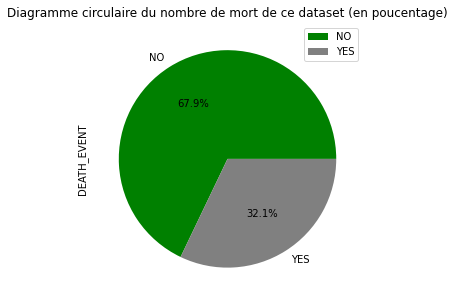

In [181]:
vocabulaire = heart_failure['DEATH_EVENT'].astype('category').cat.categories

#Ici, on vas créer un dictionnaire qui prendra v qui est le DEATH_EVENT et lui associera la nombre de fois qu'il apparait dans notre dataframe 
nbByDEATH_EVENT = {v:heart_failure.query("DEATH_EVENT == '" + str(v) + "'")['DEATH_EVENT'].count() for i,v in enumerate(vocabulaire.tolist())}

# Pour récupérer que les values du dictionnaire
NBDEATH_EVENT = []
for k,v in nbByDEATH_EVENT.items():
    NBDEATH_EVENT.append(v)

Data = {'DEATH_EVENT': NBDEATH_EVENT}
df = pd.DataFrame(Data,columns=['DEATH_EVENT'],index = list(vocabulaire))

df.plot.pie(y='DEATH_EVENT',figsize=(5, 5),autopct='%1.1f%%', colors = ['green', 'gray']) # autopct % mettre le format %

# Style
plt.title("Diagramme circulaire du nombre de mort de ce dataset (en poucentage)")
plt.show()

On constate que dans ce dataset, on as plus de données de personnes mortes.

## Histogramme des morts ou non en fonction de l'anémia

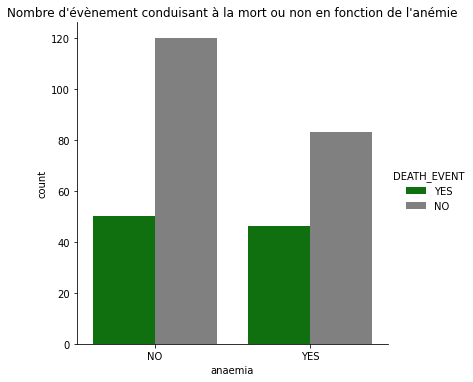

In [182]:
g = sns.catplot(x="anaemia", kind='count',hue='DEATH_EVENT' ,data=heart_failure, palette=sns.color_palette(['green', 'gray']))

# Style
plt.title("Nombre d'évènement conduisant à la mort ou non en fonction de l'anémie")
plt.show()

## Histogramme des morts ou non en fonction du diabetes

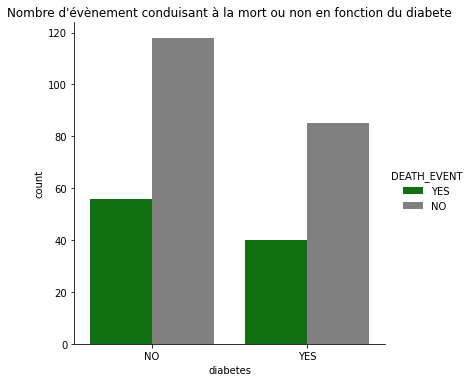

In [183]:
g = sns.catplot(x="diabetes", kind='count',hue='DEATH_EVENT' ,data=heart_failure, palette=sns.color_palette(['green', 'gray']))

# Style
plt.title("Nombre d'évènement conduisant à la mort ou non en fonction du diabete")
plt.show()

## Histogramme des morts ou non en fonction de l'hyper-tension

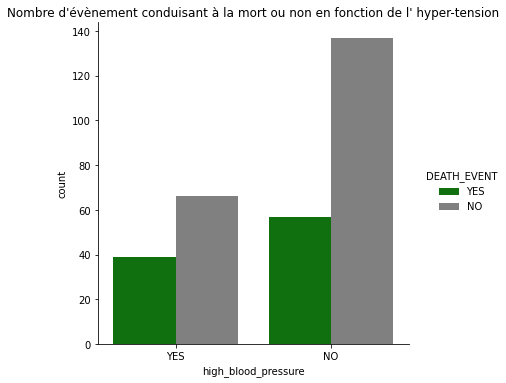

In [184]:
g = sns.catplot(x="high_blood_pressure", kind='count',hue='DEATH_EVENT' ,data=heart_failure, palette=sns.color_palette(['green', 'gray']))

# Style
plt.title("Nombre d'évènement conduisant à la mort ou non en fonction de l' hyper-tension")
plt.show()

## Histogramme des morts ou non en fonction du sexe

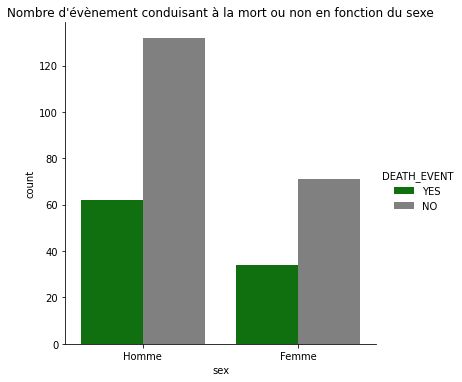

In [185]:
g = sns.catplot(x="sex", kind='count',hue='DEATH_EVENT' ,data=heart_failure, palette=sns.color_palette(['green', 'gray']))

# Style
plt.title("Nombre d'évènement conduisant à la mort ou non en fonction du sexe")
plt.show()

## Histogramme des morts ou non en fonction du patient fumeur ou non

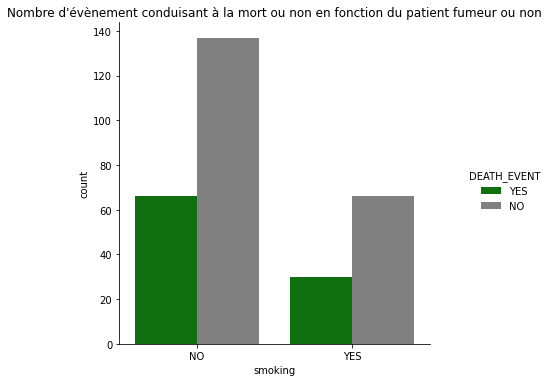

In [186]:
g = sns.catplot(x="smoking", kind='count',hue='DEATH_EVENT' ,data=heart_failure, palette=sns.color_palette(['green', 'gray']))

# Style
plt.title("Nombre d'évènement conduisant à la mort ou non en fonction du patient fumeur ou non")
plt.show()

## Répartition des morts en fonction de l'age

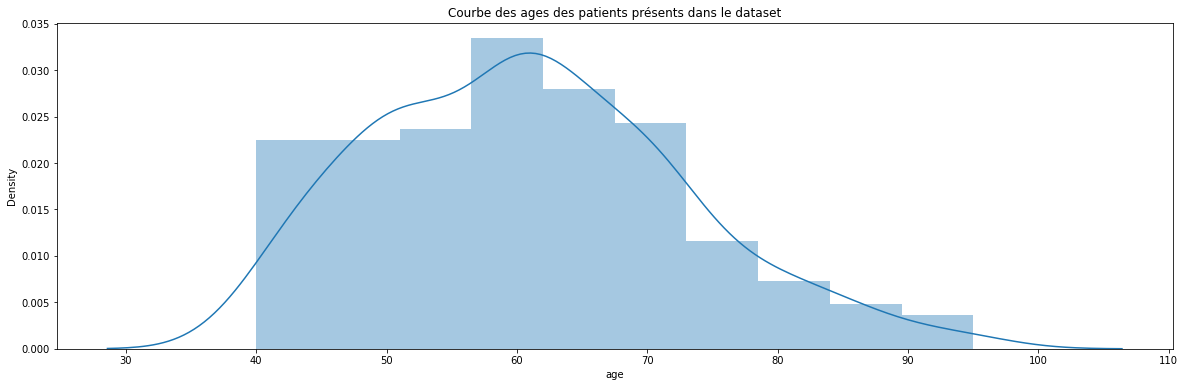

In [187]:
sns.distplot(heart_failure['age'])
plt.title("Courbe des ages des patients présents dans le dataset")
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)
plt.show()

On remarque plus que le dataset contient des patient de 40 à 95 ans.

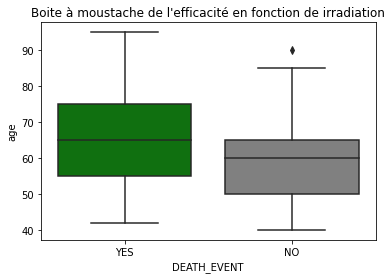

In [188]:
g = sns.boxplot(x="DEATH_EVENT", y="age", data=heart_failure,palette=sns.color_palette(['green', 'gray']))
plt.title("Boite à moustache de l'efficacité en fonction de irradiation")
plt.show()

On remarque que la 50% des age des personnes mortes d'un arrêt cardiaque sont plus en dessous que les 50% des ages des personnes ayant survécu. 

## Analyse de base terminé, reformatage à l'original pour la suite

In [189]:
labelencoder = preprocessing.LabelEncoder()

heart_failure['anaemia'] = labelencoder.fit_transform(heart_failure['anaemia'])
heart_failure['diabetes'] = labelencoder.fit_transform(heart_failure['diabetes'])
heart_failure['high_blood_pressure'] = labelencoder.fit_transform(heart_failure['high_blood_pressure'])
heart_failure['sex'] = labelencoder.fit_transform(heart_failure['sex'])
heart_failure['smoking'] = labelencoder.fit_transform(heart_failure['smoking'])
heart_failure['DEATH_EVENT_num'] = labelencoder.fit_transform(heart_failure['DEATH_EVENT'])

## Matrice de coorélation du dataset

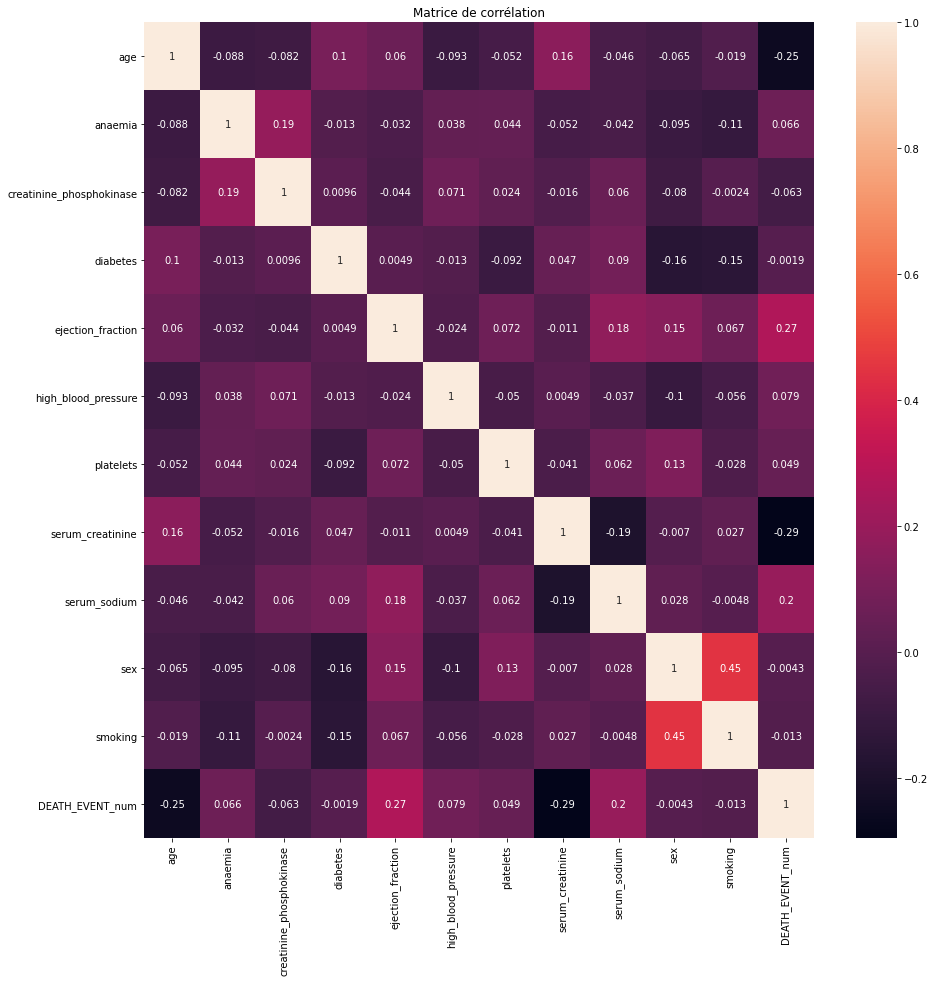

In [119]:
sns.heatmap(heart_failure.drop(columns=['time','Day','Month','Year','Date']).corr(), annot=True)
plt.title("Matrice de corrélation")

fig = mp.pyplot.gcf()
fig.set_size_inches(15,15)

plt.show()

On ne remarque aucune forte coorélation entre le DEATH_EVENT et les features

# Entrainement

## split

In [191]:
X = heart_failure.drop(columns=['time','Day','Month','Year','Date','DEATH_EVENT','DEATH_EVENT_num'])
Y = heart_failure['DEATH_EVENT'].astype('category')

In [195]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, stratify=Y,random_state=1)

## Utilisation de l'algorithme LinearSVC

On va utiliser cette algorithme car  l'on souhaite classifier un dataset de moins de 100K lignes.

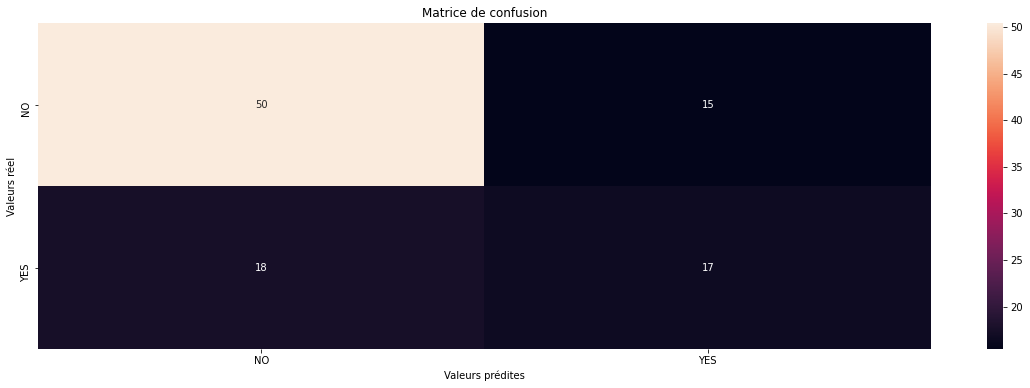

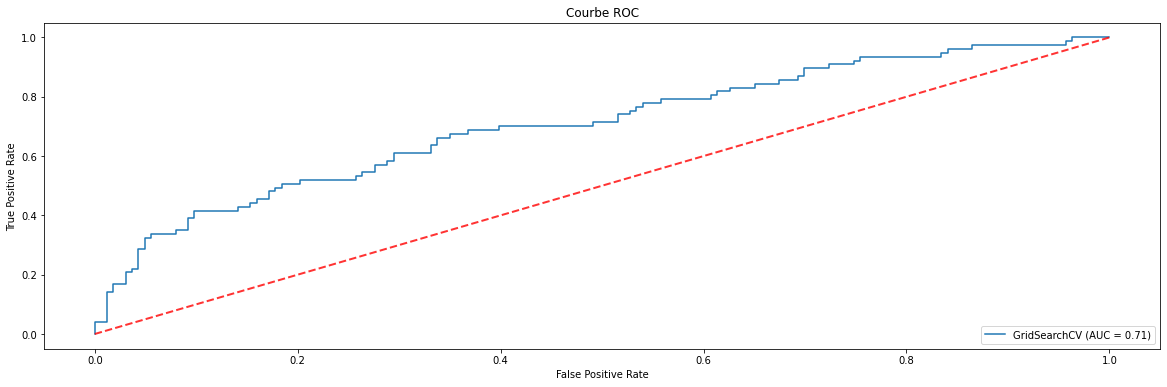

0.7484848484848485
{'dual': False, 'max_iter': 20, 'penalty': 'l2', 'random_state': 1}


In [217]:
from sklearn.svm import LinearSVC
param_grid = {
    'max_iter':[10,20,30,40,100,200,1500], 
    'random_state':[1],
    'penalty':['l1','l2'],
    'dual':[False]
}

model = LinearSVC()
model, Y_pred = pipeline(X_train, X_test, Y_train, model, param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=Y.astype('category').cat.categories.tolist())
show_cm(cm_train, Y.astype('category').cat.categories.tolist())

show_roc(model, X_test, Y_test)

#show_featuresImportance(X_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)

### Uilisation de l'algorithme RandomForest

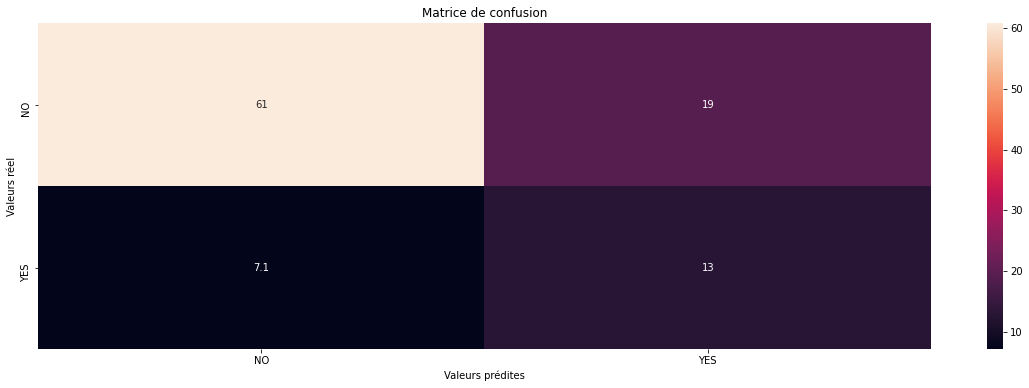

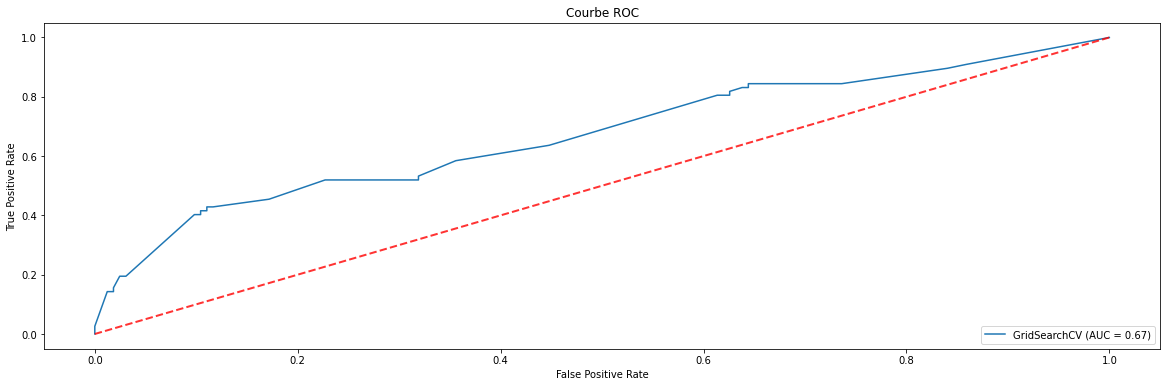

0.7803030303030304
{'max_depth': 6, 'n_estimators': 5, 'random_state': 10}


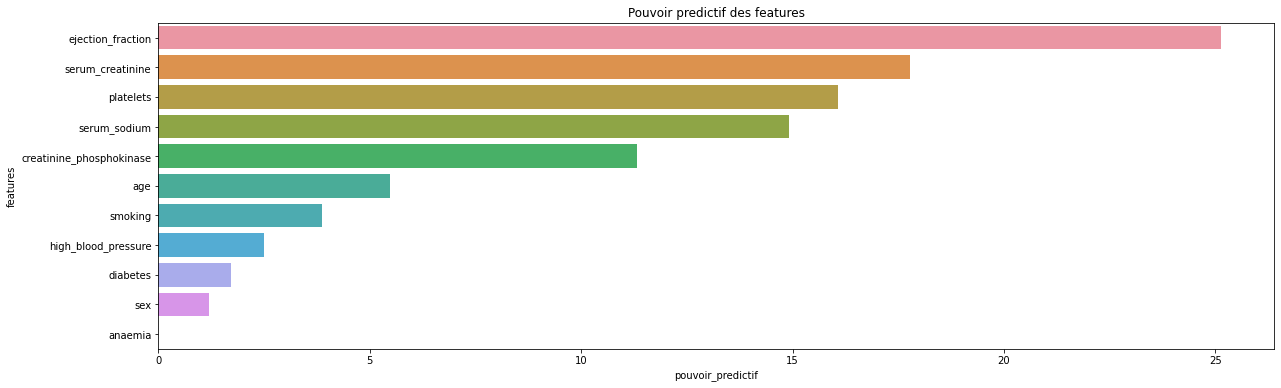

In [198]:
param_grid = {
              'random_state':[1,2,10],
              'n_estimators':[2,5,10,15,20,30],
              'max_depth':[1,4,5,6,7,9,10]
             }


model = RandomForestClassifier()
model, Y_pred = pipeline(X_train, X_test, Y_train, model, param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=Y.astype('category').cat.categories.tolist())
show_cm(cm_train, Y.astype('category').cat.categories.tolist())

show_roc(model, X_test, Y_test)

show_featuresImportance(X_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)

Le model est OK car l'accuracy atteinte est de 80%.

## Utilisation de l'algorithme DecisionTree

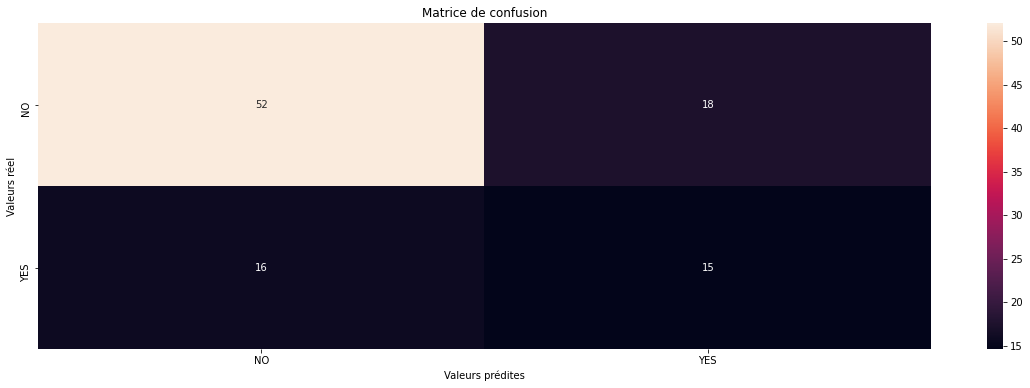

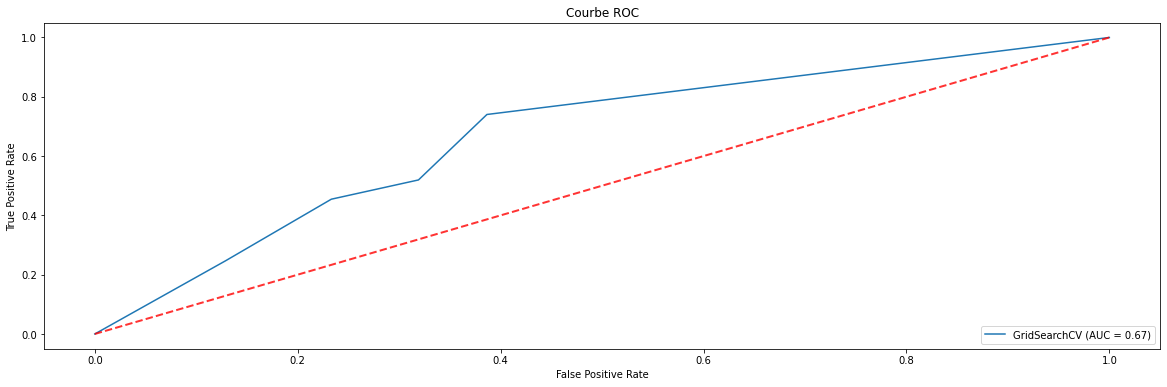

0.7469696969696971
{'criterion': 'entropy', 'max_depth': 3, 'random_state': 60, 'splitter': 'random'}


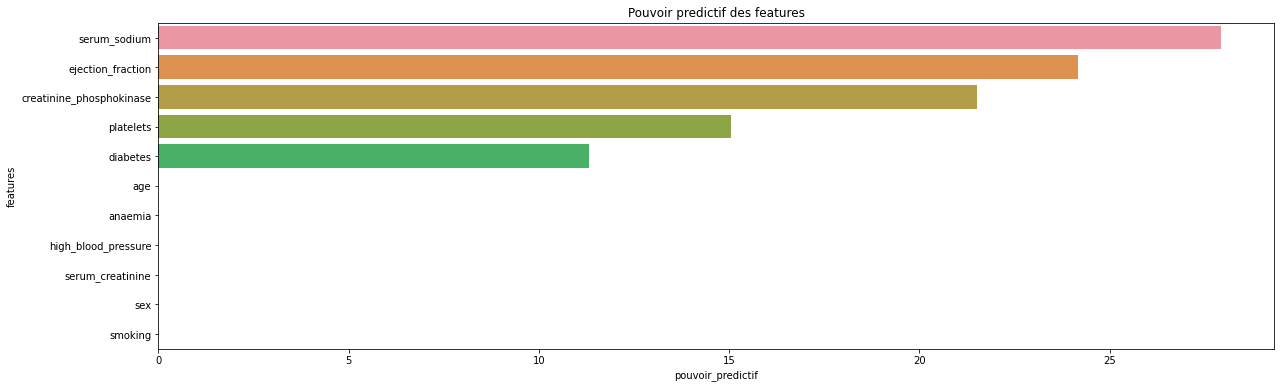

In [197]:
param_grid = {
              'random_state':[1],
              'max_depth':[1,2,3,4,5,6],
              'splitter':['best','random'],
              'criterion':['entropy']
             }

model = DecisionTreeClassifier()
model, Y_pred = pipeline(X_train, X_test, Y_train, model, param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=Y.astype('category').cat.categories.tolist())
show_cm(cm_train, Y.astype('category').cat.categories.tolist())

show_roc(model, X_test, Y_test)

show_featuresImportance(X_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)

Le model est underfitté car on n'atteint pas un score satisfaisant. De plus, on remarque que le model donne de l'importance que à la feature age.

## Utilisation de AdaBoostClassifier

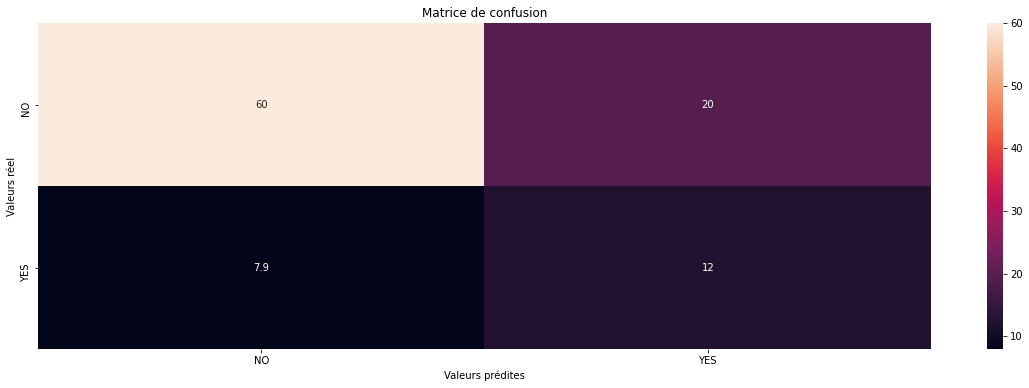

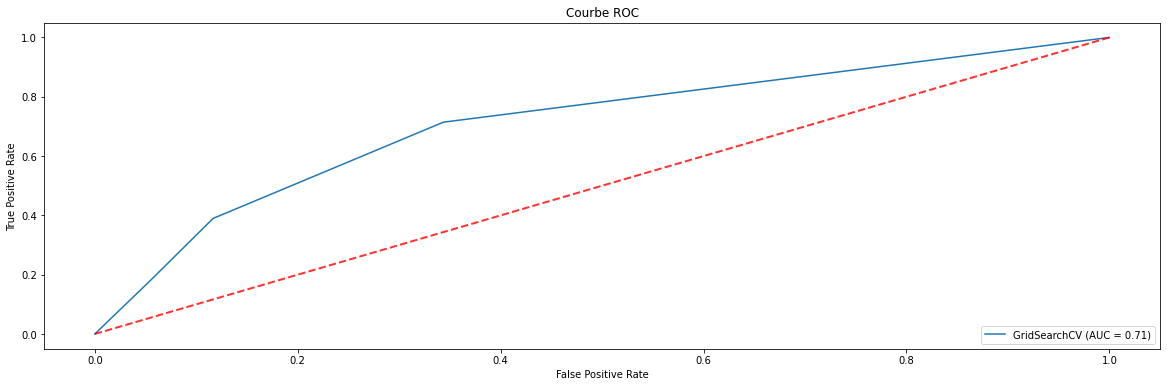

0.7484848484848485
{'algorithm': 'SAMME', 'n_estimators': 2, 'random_state': 100}


In [199]:
param_grid = {
              'random_state':[100, 200],
              'algorithm':['SAMME', 'SAMME.R'],
              'n_estimators':[1,2]
             }

model = AdaBoostClassifier()
model, Y_pred = pipeline(X_train, X_test, Y_train, model, param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=Y.astype('category').cat.categories.tolist())
show_cm(cm_train, Y.astype('category').cat.categories.tolist())

show_roc(model, X_test, Y_test)

#show_featuresImportance(X_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)

Le model est underfitté.

## Utilisation de l'algorithme LogisticRegression

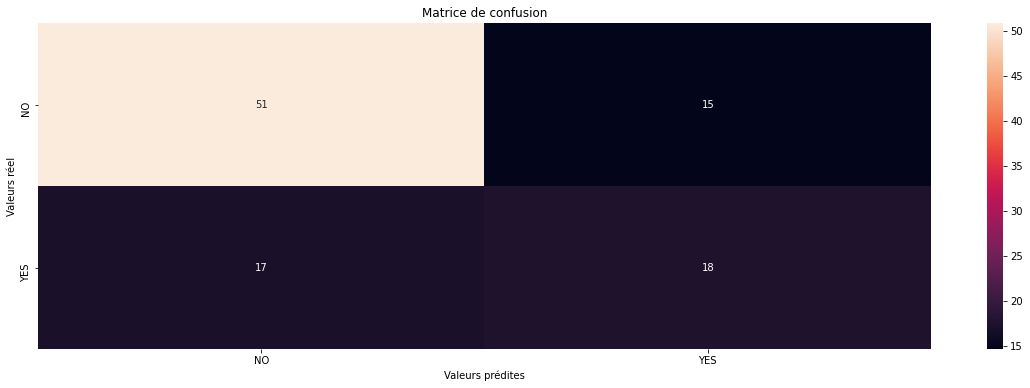

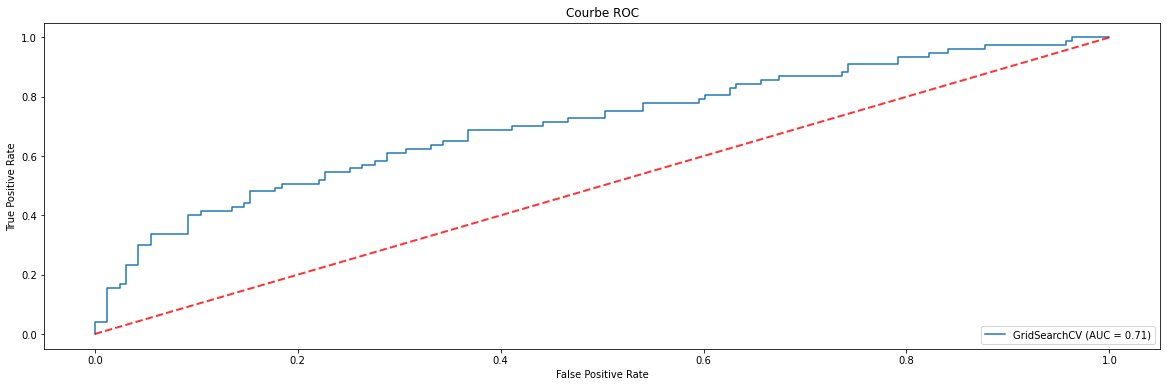

0.7484848484848485
{'C': 10, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'random_state': 100}


In [200]:
param_grid = {
              'random_state':[100, 200],
              'max_iter':[100,200,300,1000],
              'fit_intercept':[True,False],
              'C':[10],
              'penalty':['l2']
             }

model = LogisticRegression()
model, Y_pred = pipeline(X_train, X_test, Y_train, model, param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=Y.astype('category').cat.categories.tolist())
show_cm(cm_train, Y.astype('category').cat.categories.tolist())

show_roc(model, X_test, Y_test)

#show_featuresImportance(X_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)

Le model est underfitté